In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from itertools import islice
import time
import matplotlib.pyplot as plt

batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, num_workers=2)

class myVGG16(nn.Module):
    def __init__(self):
        super(myVGG16, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Полносвязанные слои
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

plt.clf()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net0 = myVGG16().to(device)
net = myVGG16().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)

def resetNet():
    net.load_state_dict(net0.state_dict())

def countAccuracy():
    correct = 0
    size = len(trainloader)
    for image, label in islice(trainloader, size):
        image, label = image.to(device), label.to(device)
        output = net(image)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == label).sum().item()
    return 100 * correct / len(trainset)

def train(name):
    xs, ys = [], []
    batch_num = len(trainloader)
    for epoch in range(10):
        running_loss = 0.0
        for inputs, labels in islice(trainloader, batch_num):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        xs.append(epoch + 1)
        ys.append(running_loss / len(trainset))
        print(f'Эпоха: {xs[-1]}, Потери: {ys[-1]}')
    plt.plot(xs, ys, label = name)
    return xs, ys

resetNet()
print(f"Точность без обучения: {countAccuracy():.2f}%")

Files already downloaded and verified
Files already downloaded and verified
Точность без обучения: 9.99%


<Figure size 640x480 with 0 Axes>

Эпоха: 1, Потери: 0.035415541412830355
Эпоха: 2, Потери: 0.027967776091098785
Эпоха: 3, Потери: 0.021794197149276735
Эпоха: 4, Потери: 0.01721447314620018
Эпоха: 5, Потери: 0.01398506853044033
Эпоха: 6, Потери: 0.01138057121694088
Эпоха: 7, Потери: 0.009398804589509964
Эпоха: 8, Потери: 0.007576136407256126
Эпоха: 9, Потери: 0.005966670065522194
Эпоха: 10, Потери: 0.004738967054188251
Точность после обучения: 91.81%


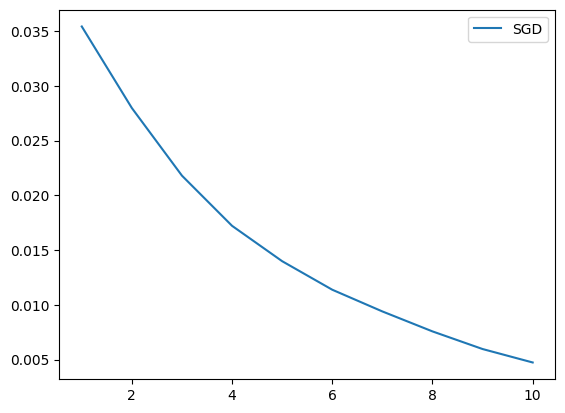

In [24]:
resetNet()
optimizer = optim.SGD(net.parameters(), lr=0.1)
xs1, ys1 = train("SGD")
print(f"Точность после обучения: {countAccuracy():.2f}%")
plt.legend()
plt.show()

Эпоха: 1, Потери: 0.03525221884965896
Эпоха: 2, Потери: 0.027798155698776247
Эпоха: 3, Потери: 0.022520701491832735
Эпоха: 4, Потери: 0.018670710830688476
Эпоха: 5, Потери: 0.015857529150247573
Эпоха: 6, Потери: 0.013721798877716065
Эпоха: 7, Потери: 0.011792355300188065
Эпоха: 8, Потери: 0.010207453654408455
Эпоха: 9, Потери: 0.008781369577050209
Эпоха: 10, Потери: 0.0074076433870196344
Точность после обучения: 84.60%


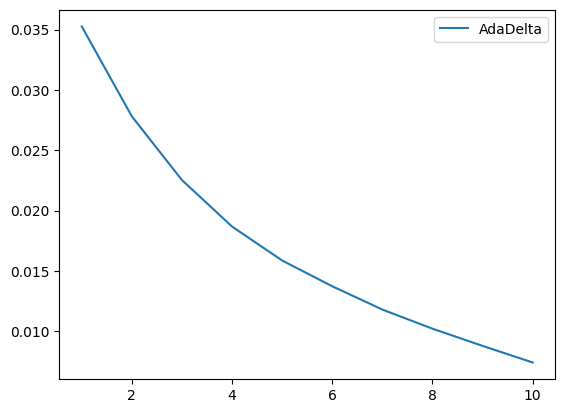

In [33]:
resetNet()
optimizer = optim.Adadelta(net.parameters(), lr=0.1)
xs2, ys2 = train("AdaDelta")
print(f"Точность после обучения: {countAccuracy():.2f}%")
plt.legend()
plt.show()

Эпоха: 1, Потери: 0.035517312610149385
Эпоха: 2, Потери: 0.02612384554386139
Эпоха: 3, Потери: 0.01937063022375107
Эпоха: 4, Потери: 0.014934966651201248
Эпоха: 5, Потери: 0.011948338241577148
Эпоха: 6, Потери: 0.009788029227256774
Эпоха: 7, Потери: 0.008022139680981637
Эпоха: 8, Потери: 0.006542308030128479
Эпоха: 9, Потери: 0.005197444339245558
Эпоха: 10, Потери: 0.00409995547965169
Точность после обучения: 92.56%


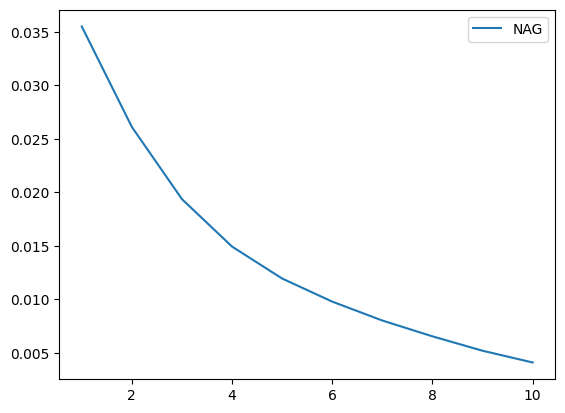

In [26]:
resetNet()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, nesterov=True)
xs3, ys3 = train("NAG")
print(f"Точность после обучения: {countAccuracy():.2f}%")
plt.legend()
plt.show()

Эпоха: 1, Потери: 0.024821199392080308
Эпоха: 2, Потери: 0.0161428102183342
Эпоха: 3, Потери: 0.012806614863872528
Эпоха: 4, Потери: 0.01058962232887745
Эпоха: 5, Потери: 0.009091974069774151
Эпоха: 6, Потери: 0.007907488061189651
Эпоха: 7, Потери: 0.006902519636154175
Эпоха: 8, Потери: 0.0061684025898575785
Эпоха: 9, Потери: 0.0055579913790524006
Эпоха: 10, Потери: 0.005062579571455717
Точность после обучения: 91.19%


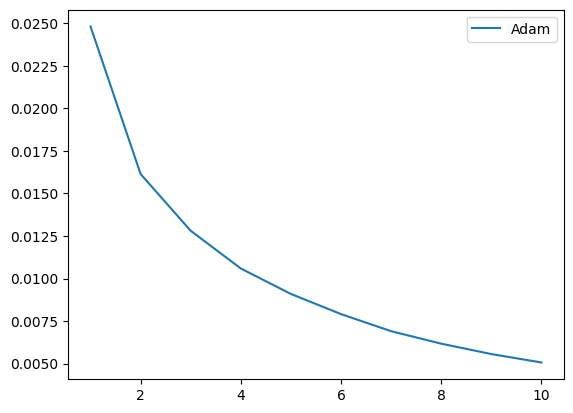

In [31]:
resetNet()
optimizer = optim.Adam(net.parameters(), lr=0.001)
xs4, ys4 = train("Adam")
print(f"Точность после обучения: {countAccuracy():.2f}%")
plt.legend()
plt.show()

In [23]:
xs1, ys1 = [], []
xs2, ys2 = [], []
xs3, ys3 = [], []
xs4, ys4 = [], []

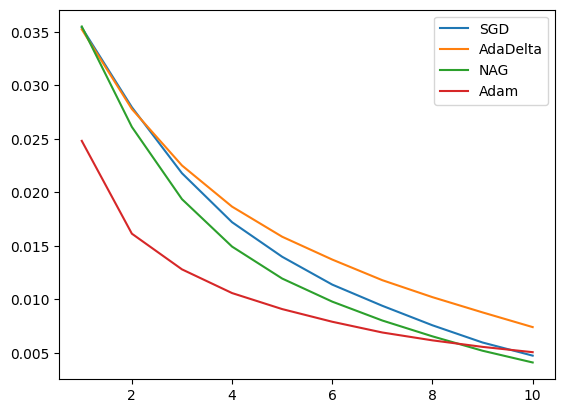

In [34]:
plt.plot(xs1, ys1, label = "SGD")
plt.plot(xs2, ys2, label = "AdaDelta")
plt.plot(xs3, ys3, label = "NAG")
plt.plot(xs4, ys4, label = "Adam")
plt.legend()
plt.show()

In [15]:
import torch
print(torch.cuda.is_available())

True
